## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.WW

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.
#%%

In [233]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
from cv import *

In [235]:
test = VGGFeatures()

In [236]:
test.forward(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 512, 14, 14])

In [237]:
content2views = ContentToViews()


In [238]:
content2views.forward(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 1])

In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [240]:
device

device(type='cuda')

In [241]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=25, train_loss_list:list =[], test_loss_list:list =[], device=device):
    model.to(device)
    model.train()
    print('Starting Training')
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                train_loss_list.append(running_loss / 100)
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            train_loss_list.append(running_loss / len(train_loader))
            print(f'Test loss: {test_loss / len(test_loader)}')
        model.train()
    print('Finished Training')

In [242]:
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import csv

In [243]:
csv_content = csv.reader(open("data/USvideos.csv", 'r'))
next(csv_content).index("views")

7

In [244]:
import pandas as pd
import numpy as np

In [245]:
import os

class ContentToViewsDataset(Dataset):
    """
    Data loader for content to views dataset
    The data is a jpg file
    The label is a scalar value
    
    """

    def __init__(self, 
                 image_dir:str, 
                 csv_file:str,
                 cap = -1,
                views_name:str = "views",  
                id_name:str = "video_id",
                transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if cap < 0:
            cap = len(os.listdir(image_dir))

        self.image_dir = image_dir
        self.files = os.listdir(image_dir)[:cap]
        self.transform = transform

        df = pd.read_csv(csv_file)
        self.views = df.set_index(id_name)[views_name].to_dict()
        self.titles = df.set_index(id_name)["title"].to_dict()
        
        

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        The output should be a scalar value,
        """
        img_name = os.path.join(self.image_dir, self.files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        video_id = self.files[idx][:-4]
        view_count = self.views[video_id]
        # title = self.titles[video_id]
        if  view_count == "":
            view_count = 0
        # if title == "":
        #         print("No title")
        #         title = " "

        # change to tensor
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32)
        view_count = torch.tensor([int(view_count)], dtype=torch.float32)
        
        return image_tensor, view_count


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


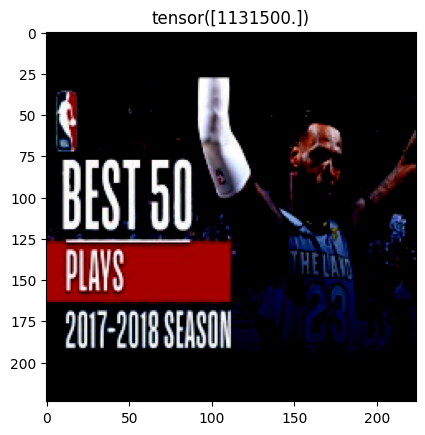

In [246]:
import matplotlib.pyplot as plt
# The raw image is 480 × 360 x3
# We will resize it to 224 × 224 x 3
# We will also normalize the image


dataset = ContentToViewsDataset('data/thumbnailUS', "data/USvideos.csv", 
                                cap=100,
                                transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))


# Show image and label
image, label = dataset[0]

image = image.numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.title(label)
plt.show()

In [247]:
# The raw image is 480 × 360
# We will resize it to 224 × 224
# We will also normalize the image

dataset = ContentToViewsDataset('data/thumbnailUS', "data/USvideos.csv", 
                                cap=100,
                                transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [248]:
# split into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
train_size = 80
test_size = 20
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [249]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

In [250]:
def start_training(model, epochs=25, train_loss_list:list = [], test_loss_list:list=[]):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train(model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs
          , train_loss_list=train_loss_list, test_loss_list=test_loss_list)

In [251]:
train_loss_list = []
test_loss_list = []

start_training(content2views, epochs=25, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

plt.plot(train_loss_list )
plt.plot(test_loss_list)
plt.show()

Starting Training
Test loss: 1643040387891.2
Test loss: 971747072409.6
Test loss: 1605198597324.8
Test loss: 1673007490662.4
Test loss: 1413166052147.2
Test loss: 4544136216576.0
Test loss: 797469599334.4
Test loss: 813480784691.2
Test loss: 1074958250803.2
Test loss: 1184214497689.6
Test loss: 1635017844326.4
Test loss: 1673005773619.2
Test loss: 1230041867878.4
Test loss: 1671879930675.2
Test loss: 1016635588608.0
Test loss: 1636184699699.2
Test loss: 1576704298188.8
